In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [174]:
#CREDIT: https://github.com/ColCarroll/ridge_map
#CODE MODIFIED FROM THIS BASE
"""3D maps with 1D lines."""

from urllib.request import urlopen
from tempfile import NamedTemporaryFile

from matplotlib.collections import LineCollection
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import rank
from skimage.morphology import square
from skimage.util import img_as_ubyte

import srtm


class FontManager:
    """Utility to load fun fonts from https://fonts.google.com/ for matplotlib.

    Find a nice font at https://fonts.google.com/, and then get its corresponding URL
    from https://github.com/google/fonts/

    Use like:

    fm = FontManager()
    fig, ax = plt.subplots()

    ax.text("Good content.", fontproperties=fm.prop, size=60)
    """

    def __init__(
        self,
        github_url="https://github.com/google/fonts/raw/main/ofl/cinzel/Cinzel%5Bwght%5D.ttf",  # pylint: disable=line-too-long
    ):
        """
        Lazily download a font.

        Parameters
        ----------
        github_url : str
            Can really be any .ttf file, but probably looks like
            "https://github.com/google/fonts/raw/main/ofl/cinzel/Cinzel%5Bwght%5D.ttf" # pylint: disable=line-too-long
        """
        self.github_url = github_url
        self._prop = None

    @property
    def prop(self):
        """Get matplotlib.font_manager.FontProperties object that sets the custom font."""
        if self._prop is None:
            with NamedTemporaryFile(delete=False, suffix=".ttf") as temp_file:
                # pylint: disable=consider-using-with
                temp_file.write(urlopen(self.github_url).read())
                self._prop = fm.FontProperties(fname=temp_file.name)
        return self._prop


class RidgeMap:
    """Main class for interacting with art.

    Keeps state around so no servers are hit too often.
    """

    def __init__(self, bbox=(-71.928864, 43.758201, -70.957947, 44.465151), font=None):
        """Initialize RidgeMap.

        Parameters
        ----------
        bbox : list-like of length 4
            In the form (long, lat, long, lat), describing the
            (bottom_left, top_right) corners of a box.
            http://bboxfinder.com is a useful way to find these tuples.
        font : matplotlib.font_manager.FontProperties
            Optional, a custom font to use. Defaults to Cinzel Regular.
        """
        self.bbox = bbox
        self._srtm_data = srtm.get_data()
        if font is None:
            font = FontManager().prop
        self.font = font

    @property
    def lats(self):
        """Left and right latitude of bounding box."""
        return (self.bbox[1], self.bbox[3])

    @property
    def longs(self):
        """Bottom and top longitude of bounding box."""
        return (self.bbox[0], self.bbox[2])

    def get_elevation_data(self, num_lines=80, elevation_pts=300, viewpoint="south"):
        """Fetch elevation data and return a numpy array.

        Parameters
        ----------
        num_lines : int
            Number of horizontal lines to draw
        elevation_pts : int
            Number of points on each line to request. There's some limit to
            this that srtm enforces, but feel free to go for it!
        viewpoint : str in ["south", "west", "north", "east"] (default "south")
            The compass direction from which the map will be visualised.

        Returns
        -------
        np.ndarray
        """
        if viewpoint in ["east", "west"]:
            num_lines, elevation_pts = elevation_pts, num_lines
        values = self._srtm_data.get_image(
            (elevation_pts, num_lines), self.lats, self.longs, 5280, mode="array"
        )

        switch = {"south": 0, "west": 3, "north": 2, "east": 1}
        rotations = switch[viewpoint]
        values = np.rot90(m=values, k=rotations)
        return values

    def preprocess(
        self, *, values=None, water_ntile=10, lake_flatness=3, vertical_ratio=40
    ):
        """Get map data ready for plotting.

        You can do this yourself, and pass an array directly to plot_map. This
        gathers all nan values, the lowest `water_ntile` percentile of elevations,
        and anything that is flat enough, and sets the values to `nan`, so no line
        is drawn. It also exaggerates the vertical scale, which can be nice for flat
        or mountainy areas.

        Parameters
        ----------
        values : np.ndarray
            An array to process, or fetch the elevation data lazily here.
        water_ntile : float in [0, 100]
            Percentile below which to delete data. Useful for coasts or rivers.
            Set to 0 to not delete any data.
        lake_flatness : int
            How much the elevation can change within 3 squares to delete data.
            Higher values delete more data. Useful for rivers, lakes, oceans.
        vertical_ratio : float > 0
            How much to exaggerate hills. Kind of arbitrary. 40 is reasonable,
            but try bigger and smaller values!

        Returns
        -------
        np.ndarray
            Processed data.
        """
        if values is None:
            values = self.get_elevation_data()
        nan_vals = np.isnan(values)

        values[nan_vals] = np.nanmin(values)
        self.minv = np.min(values)
        self.maxv = np.max(values)
        self.vertical_ratio = vertical_ratio
        values = (values - self.minv) / (self.maxv - self.minv)

        is_water = values < np.percentile(values, water_ntile)
        is_lake = rank.gradient(img_as_ubyte(values), square(3)) < lake_flatness

        values[nan_vals] = np.nan
        values[np.logical_or(is_water, is_lake)] = np.nan
        values = vertical_ratio * values[-1::-1]  # switch north and south
        return values
    
    def approx_elevation(self, lat, long, values):
        return values[int(lat), int(long)]
    
    # pylint: disable=too-many-arguments,too-many-locals
    def plot_map_with_extra_lines(
        self,
        values=None,
        extra_lines=[],#should be a list of 3x? arrays with [[lat], [long], [elev]] (if elev is None, elev is inferred as ground level)
        label="The White\nMountains",
        label_x=0.62,
        label_y=0.15,
        label_verticalalignment="bottom",
        label_size=60,
        line_color="black",
        kind="gradient",
        linewidth=2,
        background_color=(0.9255, 0.9098, 0.9255),
        size_scale=20,
        ax=None,
        experimental_zorder=True,
        no_label=True,
        verbose=False
    ):
        """Plot the map.

        Lots of nobs, and they're all useful to sometimes turn.

        Parameters
        ----------
        values : np.ndarray
            Array of elevations to plot. Defaults to the elevations at the provided
            bounding box.
        label : string
            Label to place on the map. Use an empty string for no label.
        label_x : float in [0, 1]
            Where to position the label horizontally
        label_y : float in [0, 1]
            Where to position the label vertically
        label_verticalalignment: "top" or "bottom"
            Whether the label_x and label_y refer to the top or bottom left corner
            of the label text box
        label_size : int
            fontsize of the label
        line_color : string or callable
            colors for the map. A callable will be fed the scaled index in [0, 1]
        kind : {"gradient" | "elevation"}
            If you provide a colormap to `line_color`, "gradient" colors by the line index, and
            "elevation" colors by the actual elevation along the line.
        linewidth : float
            Width of each line in the map
        background_color : color
            For the background of the map and figure
        scale_size : float
            If you are printing this, make this number bigger.
        ax : matplotlib Axes
            You can pass your own axes!

        Returns
        -------
        matplotlib.Axes
        """
        if kind not in {"gradient", "elevation"}:
            raise TypeError("Argument `kind` must be one of 'gradient' or 'elevation'")
        if values is None:
            values = self.preprocess()

        if ax is None:
            ratio = (self.lats[1] - self.lats[0]) / (self.longs[1] - self.longs[0])
            _, ax = plt.subplots(figsize=(size_scale, size_scale * ratio))

        x = np.arange(values.shape[1])
        norm = plt.Normalize(np.nanmin(values), np.nanmax(values))
        for idx, row in enumerate(values):
            y_base = -6 * idx * np.ones_like(row)
            y = row + y_base
            if callable(line_color) and kind == "elevation":
                points = np.array([x, y]).T.reshape((-1, 1, 2))
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lines = LineCollection(
                    segments, cmap=line_color, zorder=idx + 1, norm=norm
                )
                lines.set_array(row)
                lines.set_linewidth(linewidth)
                ax.add_collection(lines)
            else:
                if callable(line_color) and kind == "gradient":
                    color = line_color(idx / values.shape[0])
                else:
                    color = line_color

                ax.plot(x, y, "-", color=color, zorder=idx, lw=linewidth)
            ax.fill_between(x, y_base, y, color=background_color, zorder=idx)
        lats_norm = lambda _x: -values.shape[0] * (_x - self.lats[1])/(self.lats[1] - self.lats[0])
        longs_norm = lambda _x: values.shape[1] * (_x - self.longs[0])/(self.longs[1] - self.longs[0])
        elevs_norm = lambda _x: self.vertical_ratio * ((_x - self.minv) / (self.maxv - self.minv))
        extra_lines = [np.array([
            i[0],
            i[1],
            np.array([
                (elevs_norm(_i) if _i is not None else self.approx_elevation(
                    lats_norm(i[0][n]),
                    longs_norm(i[1][n]),
                    values
                )) for n, _i in enumerate(i[2])
            ])])
            for i in extra_lines
        ]
        if verbose:
            print(extra_lines)
        for idx, (lats, longs, elevs) in enumerate(extra_lines):
            _lats = lats_norm(lats)
            _longs = longs_norm(longs)
            y_base = -6 * _lats * np.ones_like(elevs)
            y = elevs + y_base
            x = _longs
            if callable(line_color) and kind == "elevation":
                points = np.array([x, y]).T.reshape((-1, 1, 2))
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                if experimental_zorder:
                    for n, seg in enumerate(segments):
                        color = line_color(norm(elevs[n]))
                        ax.plot(seg[:, 0], seg[:, 1], "-", c=color, zorder=_lats[n])
                else:
                    lines = LineCollection(
                        segments, cmap=line_color, zorder=idx, norm=norm
                    )
                    lines.set_array(elevs)
                    lines.set_linewidth(linewidth)
                    ax.add_collection(lines)
            else:
                if callable(line_color) and kind == "gradient":
                    color = line_color(_lats[0] / values.shape[0])
                else:
                    color = line_color
                if experimental_zorder:
                    points = np.array([x, y]).T.reshape((-1, 1, 2))
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    for n, seg in enumerate(segments):
                        if callable(line_color) and kind == "gradient":
                            color = line_color(_lats[n] / values.shape[0])
                        ax.plot(seg[:, 0], seg[:, 1], "-", c=color, zorder=_lats[n])
                else:
                    ax.plot(x, y, "-", color=color, zorder=_lats[0], lw=linewidth)
            #ax.fill_between(x, y_base, y, color=background_color, zorder=idx)

        if not no_label:
            ax.text(
                label_x,
                label_y,
                label,
                transform=ax.transAxes,
                fontproperties=self.font,
                size=label_size,
                verticalalignment=label_verticalalignment,
                bbox={"facecolor": background_color, "alpha": 1, "linewidth": 0},
                zorder=len(values) + 10,
            )

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_facecolor(background_color)
        return ax

In [172]:
box = (-135, 15, -65, 70)
rm = RidgeMap(box)
el = [[[34, 42, 39.106667], [-118, -110, -94.676392], [None, None, None]]]
try:
    values
except:
    values = rm.get_elevation_data(num_lines=200)

[array([[  34.        ,   42.        ,   39.106667  ],
       [-118.        , -110.        ,  -94.676392  ],
       [   1.47336162,   24.63460632,    4.78547855]])]


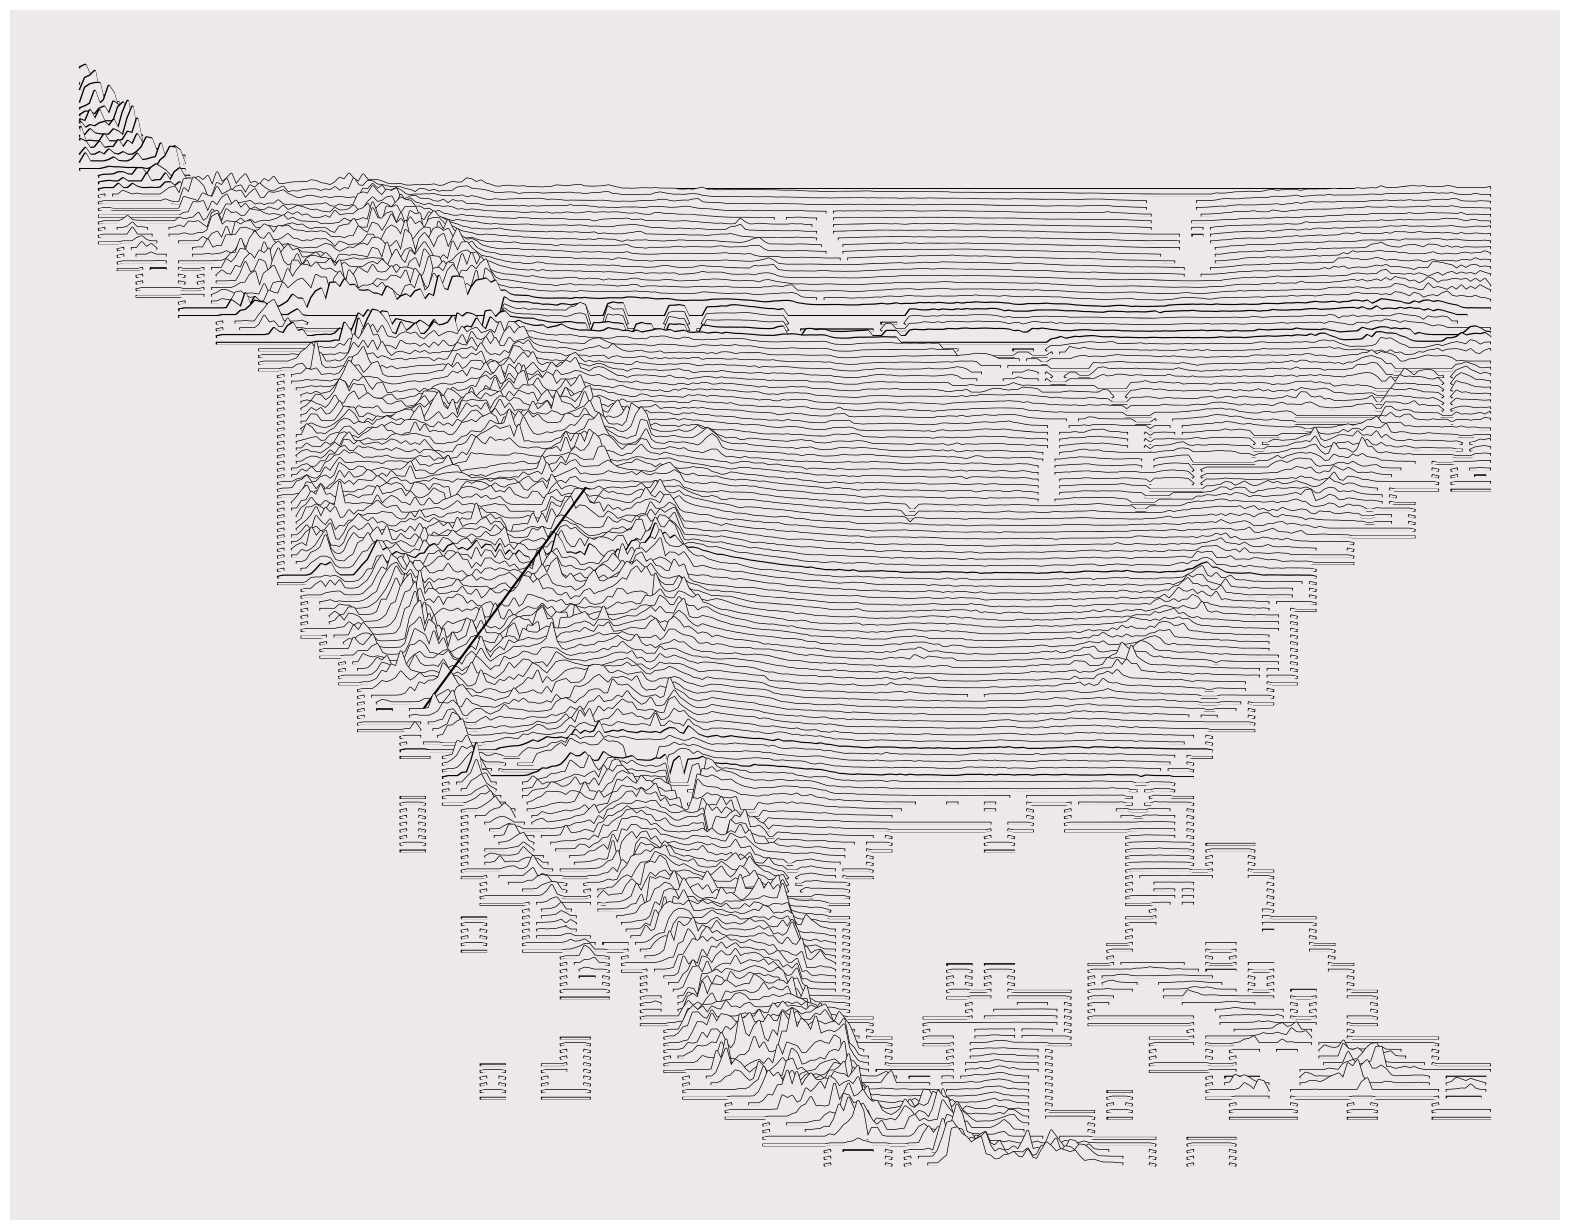

In [173]:
VERTICAL_RATIO = 50
_v = rm.preprocess(values=values, lake_flatness=1, water_ntile=31, vertical_ratio=VERTICAL_RATIO)
rm.plot_map_with_extra_lines(values=_v, extra_lines=el, no_label=True, experimental_zorder=True)
plt.show()